In [44]:
#import Pkg
#Pkg.add("JuMP")
#Pkg.add("GLPK")
#Pkg.add("Gruobi")
#Pkg.add("DataFrames")
#Pkg.add("CSV")

In [45]:
using JuMP, GLPK
using DataFrames
using CSV

In [46]:
#load cost data
con_generation = CSV.File("../data/conventional_generators.csv") |> DataFrame

#load wind_technicaldata
wind_generation = CSV.File("../data/wind_farms.csv") |> DataFrame

# load wind profile
wind_profile = CSV.File("../data/wind_powerprofile_200.csv") |> DataFrame


Row,Hour,W1,W2,W3,W4,W5,W6
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,76.8921,101.54,92.8003,95.3709,96.002,70.9073
2,2,66.8277,90.9989,109.167,107.937,103.616,112.618
3,3,78.422,116.959,142.88,134.78,128.276,133.832
4,4,64.1437,134.249,159.57,133.664,142.969,154.233
5,5,102.22,145.507,160.944,165.303,144.03,161.49
6,6,134.039,131.112,157.023,161.828,144.636,155.222
7,7,146.517,153.67,141.566,159.927,152.86,153.604
8,8,143.176,163.392,155.294,170.805,158.643,164.307
9,9,163.297,144.48,172.638,185.318,150.901,166.558


In [47]:
#demand bids
name = "demand_hour_0.csv"
demand_bids = CSV.File("../data/demand_bids_hour/" * name) |> DataFrame
 
# number of convential generators
G = size(con_generation, 1)

# number of demand
D = size(demand_bids, 1)

# number of wind generators
W = size(wind_generation, 1)

4

In [48]:
# Initialize the DataFrame directly without dynamic column names
result_df = DataFrame(hour = Int[], objective_value = Float64[])
equilibrium_df = DataFrame(hour = Int[], market_price = Float64[], market_quantity = Float64[])

# For x variables, manually add each column. This is a one-time setup.
for i in 1:G
    result_df[!, Symbol("x_con$i")] = Float64[]
end

# For w variables, manually add each column. This is a one-time setup.
for i in 1:W
    result_df[!, Symbol("x_wind$i")] = Float64[]
end

# For y variables, manually add each column. This is a one-time setup.
for i in 1:D
    result_df[!, Symbol("y$i")] = Float64[]
end

In [49]:

hour = 1
# Create a new model with GLPK solver
model = Model(GLPK.Optimizer)

# Define the decision variables for every generator
unregister(model, :x)  # Unregister the existing variable named "x" from the model

#demand bids
name = "demand_hour_" * string(hour-1) * ".csv"
demand_bids = CSV.File("../data/demand_bids_hour/" * name) |> DataFrame

# number of demand
D = size(demand_bids, 1)

#@variable(model, x_bin[1:G], Bin)  # binary variable for on/off status
@variable(model, x_con[1:G])  # power output variable

for g in 1:G
set_lower_bound(x_con[g], 0)  # Set the lower bound
set_upper_bound(x_con[g], con_generation[g,6])  # Set the upper bound
end

# Add constraints for each plant
#for g in 1:G
#  @constraint(model, x_con[g] >= capacity[g,4] * x_bin[g])  # If plant i is on, power must be at least 15
#  @constraint(model, x_con[g] <= capacity[g,3] * x_bin[g])  # If plant i is on, power cannot exceed 20
#end

# wind decision variables
@variable(model, x_wind[1:W])  # Create the new variable
for g in 1:W
    set_lower_bound(x_wind[g], 0)  # Set the lower bound
    set_upper_bound(x_wind[g], wind_profile[hour,g+1])  # Set the upper bound
end

# decision variables for demand
@variable(model, y[1:size(demand_bids, 1)])  # Create the new variable
for bid in 1:D
    set_lower_bound(y[bid], 0)  # Set the lower bound
    set_upper_bound(y[bid], demand_bids[bid,2])  # Set the upper bound
end


# Define the objective function
@objective(model, Max, sum(demand_bids[d,3] * y[d] for d in 1:D) - sum(con_generation[g,3] * x_con[g] for g in 1:G))

# Add the constraint for the balance between supply and demand
@constraint(model, BalanceConstraint,  sum(x_con[g] for g in 1:G) + sum(x_wind[w] for w in 1:W) - sum(y[d] for d in 1:D) == 0)

# Print the model
#print(model)

# Solve the model
optimize!(model)

# Check the status of the solution
status = termination_status(model)
if status == MOI.OPTIMAL
    println("Hour ", hour, ": Optimal solution found")
    #println("Objective value: ", objective_value(model))
    #println("x values: ", [value(x[i]) for i in 1:G])
    #println("x_wind values: ", [value(x_wind[i]) for i in 1:W])
    #println("y values: ", [value(y[i]) for i in 1:D])
    println(dual(BalanceConstraint))
    #add dual values to dataframe
    push!(equilibrium_df, [hour, dual(BalanceConstraint), sum(value(y[i]) for i in 1:D)])

    #save results to dataframe
    push!(result_df, [hour, objective_value(model), [value(x_con[i]) for i in 1:G]..., [value(x_wind[i]) for i in 1:W]..., [value(y[i]) for i in 1:D]...])

elseif status == MOI.INFEASIBLE
    println("Hour ", hour, ": No feasible solution found")
else
    println("Hour ", hour, ": Solver status: ", status)
end


Hour 1: Optimal solution found
5.809337482258483


Row,hour,objective_value,x_con1,x_con2,x_con3,x_con4,x_con5,x_con6,x_con7,x_con8,x_con9,x_con10,x_con11,x_con12,x_wind1,x_wind2,x_wind3,x_wind4,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,6926.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,76.8921,101.54,92.8003,95.3709,85.6092,0.0,0.0,106.608,46.8428,10.1874,67.8413,0.0,0.0,0.0,0.0,121.145,0.0,0.0,0.0,0.0,208.37


In [50]:
result_df

Row,hour,objective_value,x_con1,x_con2,x_con3,x_con4,x_con5,x_con6,x_con7,x_con8,x_con9,x_con10,x_con11,x_con12,x_wind1,x_wind2,x_wind3,x_wind4,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,6926.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,76.8921,101.54,92.8003,95.3709,85.6092,0.0,0.0,106.608,46.8428,10.1874,67.8413,0.0,0.0,0.0,0.0,121.145,0.0,0.0,0.0,0.0,208.37


In [72]:
#prepare the plot
demand_sort = DataFrame(Hour = Int[], Quantity_MW = Float64[], Price_MWh = Float64[])
for d in 1:D
    push!(demand_sort, (Hour = 1, Quantity_MW = 0, Price_MWh = demand_bids[d, 3]))
    push!(demand_sort, (Hour = 1, Quantity_MW = demand_bids[d, 2], Price_MWh = demand_bids[d, 3]))
end
sort!(demand_sort, :Price_MWh, rev=true)

supply_sort = DataFrame(Hour = Int[], Quantity_MW = Float64[], Price_MWh = Float64[])
for g in 1:G
    push!(supply_sort, (Hour = 1, Quantity_MW = 0, Price_MWh = con_generation[g,3]))
    push!(supply_sort, (Hour = 1, Quantity_MW = con_generation[g,6], Price_MWh = con_generation[g,3]))
end
for w in 1:W
    push!(supply_sort, (Hour = 1, Quantity_MW = 0, Price_MWh = 0))
    push!(supply_sort, (Hour = 1, Quantity_MW = wind_profile[hour,w+1], Price_MWh = 0))
end

sort!(supply_sort, :Price_MWh)

for d in 2:2*D
    demand_sort[d,2] += demand_sort[d-1,2]
end
for s in 2:size(supply_sort,1)
    supply_sort[s,2] += supply_sort[s-1,2]
end

demand_sort
supply_sort

Row,Hour,Quantity_MW,Price_MWh
,Int64,Float64,Float64
1,1,0.0,0.0
2,1,76.8921,0.0
3,1,76.8921,0.0
4,1,178.432,0.0
5,1,178.432,0.0
6,1,271.232,0.0
7,1,271.232,0.0
8,1,366.603,0.0
9,1,366.603,5.47


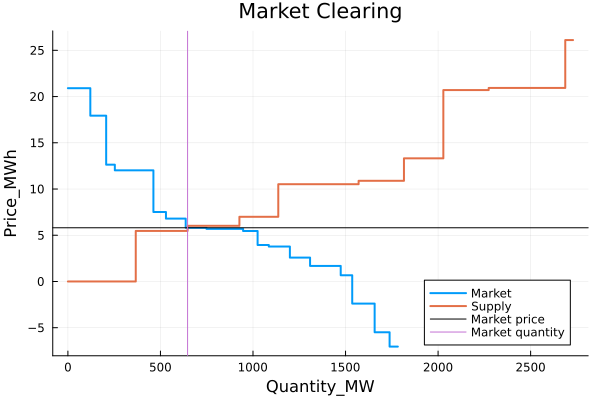

In [73]:
using Plots
plot(demand_sort.Quantity_MW, demand_sort.Price_MWh, label="Market", xlabel="Quantity_MW", ylabel="Price_MWh", title="Market Clearing", lw=2)
plot!(supply_sort.Quantity_MW, supply_sort.Price_MWh, label="Supply", lw=2)
hline!([equilibrium_df[1, 2]], color="black", label="Market price")
vline!([equilibrium_df[1, 3]], label="Market quantity")



In [53]:
#save result_df to csv
CSV.write("results/market_clearing_model1.csv", result_df)
CSV.write("results/equilibrium_model1.csv", equilibrium_df)

"results/equilibrium_model1.csv"